# Compling the fish dataset

Based on the Fish Tree of Life ([Rabosky DL et al. Nature '18](https://doi.org/10.1038/s41586-018-0273-1)) and OrthoDB v11 ([Kuznetsov D et al. NAR '23](https://doi.org/10.1093/nar/gkac998)).

[Prev1](../00-get-pubdata/240706-1-fishtree.ipynb) & [2](../00-get-pubdata/240706-2-ncbi-assembly-summary.ipynb): Data download  
[Next](./240706-2-complie-cv.ipynb): Compile CV datasets

## Procedure

1. Reconcile taxonomy from ODB (`odb11v0_species.tab.gz`) to the fish ToL tree (Timetree `actinopt_12k_treePL.tre.xz`)
    1. Species name exact match => Pass
    1. Synonym found (manual search) => Pass 
    1. Species not in tree but classified in the fish ToL (`PFC_taxonomy.csv.xz`)
        1. Another species of the same genus reconciled => Drop
        1. Otherwise => Pass (Map to closely related species in tree)
    1. Otherwise (i.e., not in the fish ToL)  => Drop 
1. Filtering (Downsampling) by assembly information of the NCBI RefSeq genomes used as the source of ODB.
    1. Drop atypical assemblies
    1. Drop assembly level 'Scaffold' and 'Contig'
    1. Manual rescue

In [1]:
import gzip, json
import lzma

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ete3 import Tree
from tqdm.auto import tqdm

from colaml import *
from colaml.misc import phyplot, dataplot
from myconfig import DATASET_DIR, METADATA_DIR, PUBDATA_DIR

## 1. Reconcile taxonomy (ODB -> tree)

### Load ODB

In [2]:
ODB11_DIR = PUBDATA_DIR / 'orthodb11'
FISHTREE_DIR = PUBDATA_DIR / 'fishtree'

In [3]:
levels = pd.read_csv(
    ODB11_DIR / 'odb11v0_levels.tab.gz', sep='\t', na_values='\\N', 
    names=['lvtaxid', 'sciname', 'numgenes', 'numOGs', 'numspp']
)

In [4]:
lv2spp = pd.read_csv(
    ODB11_DIR / 'odb11v0_level2species.tab.gz', index_col='orgid', sep='\t', 
    names=['toplv', 'orgid', 'numhop', 'selected_lvs'], converters=dict(selected_lvs=eval)
)
assert lv2spp.index.is_unique and lv2spp.index.notna().all()

In [5]:
odbspp = pd.read_csv(
    ODB11_DIR / 'odb11v0_species.tab.gz', index_col='orgid', sep='\t', 
    names=['taxid', 'orgid', 'sciname', 'asmid', 'numgenes', 'numOGs', 'mapping_type']
).assign(
    sciname=lambda df: df['sciname'].str.replace(' ', '_')
)
assert odbspp.index.is_unique and odbspp.index.notna().all()

In [6]:
hits = levels.query('sciname == "Actinopterygii"')
display(hits)
actinopt_taxid, = hits['lvtaxid']

,lvtaxid,sciname,numgenes,numOGs,numspp
265,7898,Actinopterygii,3441248.0,44723.0,135.0


In [7]:
fish_odbspp = odbspp.loc[lv2spp['selected_lvs'].apply(lambda levels: actinopt_taxid in levels)]

### Load tree

In [8]:
with lzma.open(FISHTREE_DIR / 'actinopt_12k_treePL.tre.xz', 'rt') as file:
    fish_tree = Tree(file.read())
    
pd.Series(fish_tree.get_leaf_names())

0                Gambusia_marshi
1                Gambusia_panuco
2                Gambusia_regani
3                Gambusia_aurata
4              Gambusia_hurtadoi
                  ...           
11633        Polypterus_congicus
11634     Polypterus_retropinnis
11635    Polypterus_mokelembembe
11636    Polypterus_ornatipinnis
11637         Polypterus_weeksii
Length: 11638, dtype: object

## 1A. Exact match

In [9]:
exact_match = {*fish_odbspp['sciname']} & {*fish_tree.get_leaf_names()}

with pd.option_context('display.max_rows', 1000):
    print(len(exact_match))
    display(sorted(exact_match))

120


['Acanthochromis_polyacanthus',
 'Acanthopagrus_latus',
 'Acipenser_ruthenus',
 'Alosa_alosa',
 'Alosa_sapidissima',
 'Amphiprion_ocellaris',
 'Anabas_testudineus',
 'Anarrhichthys_ocellatus',
 'Anguilla_anguilla',
 'Archocentrus_centrarchus',
 'Astatotilapia_calliptera',
 'Astyanax_mexicanus',
 'Austrofundulus_limnaeus',
 'Betta_splendens',
 'Boleophthalmus_pectinirostris',
 'Carassius_auratus',
 'Chanos_chanos',
 'Cheilinus_undulatus',
 'Chelmon_rostratus',
 'Clupea_harengus',
 'Colossoma_macropomum',
 'Coregonus_clupeaformis',
 'Cottoperca_gobio',
 'Cyclopterus_lumpus',
 'Cyprinodon_tularosa',
 'Cyprinus_carpio',
 'Danio_rerio',
 'Denticeps_clupeoides',
 'Echeneis_naucrates',
 'Epinephelus_lanceolatus',
 'Erpetoichthys_calabaricus',
 'Esox_lucius',
 'Etheostoma_cragini',
 'Etheostoma_spectabile',
 'Gadus_morhua',
 'Gambusia_affinis',
 'Girardinichthys_multiradiatus',
 'Gouania_willdenowi',
 'Gymnodraco_acuticeps',
 'Hippocampus_comes',
 'Hippoglossus_hippoglossus',
 'Hippoglossus_st

## 1B. Synonym

In [10]:
unlinked = {*fish_odbspp['sciname']} - {*fish_tree.get_leaf_names()}
unlinked

{'Cynoglossus_semilaevis',
 'Cyprinodon_variegatus',
 'Electrophorus_electricus',
 'Fundulus_heteroclitus',
 'Gasterosteus_aculeatus_aculeatus',
 'Haplochromis_burtoni',
 'Notolabrus_celidotus',
 'Oryzias_melastigma',
 'Paramormyrops_kingsleyae',
 'Poecilia_formosa',
 'Pundamilia_nyererei',
 'Puntigrus_tetrazona',
 'Salvelinus_alpinus',
 'Seriola_lalandi_dorsalis',
 'Sinocyclocheilus_anshuiensis'}

In [11]:
# subspecies
display({
    name
    for name in fish_tree.get_leaf_names()
    if name.startswith(tuple(unlinked))
})
display({
    name
    for name in unlinked
    if name.startswith(tuple(fish_tree.get_leaf_names()))
})

{'Cyprinodon_variegatus_ovinus',
 'Cyprinodon_variegatus_variegatus',
 'Fundulus_heteroclitus_heteroclitus',
 'Salvelinus_alpinus_alpinus'}

{'Gasterosteus_aculeatus_aculeatus', 'Seriola_lalandi_dorsalis'}

In [12]:
# synonym found
{*fish_tree.get_leaf_names()} & {'Astatotilapia_burtoni', 'Haplochromis_nyererei', 'Systomus_tetrazona'}

{'Astatotilapia_burtoni', 'Haplochromis_nyererei', 'Systomus_tetrazona'}

In [13]:
synonym = {
    'Cyprinodon_variegatus_variegatus'  : 'Cyprinodon_variegatus'           , 
    'Fundulus_heteroclitus_heteroclitus': 'Fundulus_heteroclitus'           , 
    'Salvelinus_alpinus_alpinus'        : 'Salvelinus_alpinus'              , 
    'Gasterosteus_aculeatus'            : 'Gasterosteus_aculeatus_aculeatus', 
    'Seriola_lalandi'                   : 'Seriola_lalandi_dorsalis'        ,
    
    'Astatotilapia_burtoni'             : 'Haplochromis_burtoni'            , 
    'Haplochromis_nyererei'             : 'Pundamilia_nyererei'             , 
    'Systomus_tetrazona'                : 'Puntigrus_tetrazona'             , 
}   

## 1C. Not in timetree, but classified in the fish ToL

In [14]:
pfc = pd.read_csv(
    FISHTREE_DIR / 'PFC_taxonomy.csv.xz', 
    converters={'genus.species': lambda binom: binom.replace(' ', '_')}
)

pfc_unlinked = pfc.loc[
    pfc['genus.species'].isin(unlinked), 
    ['class', 'order', 'family', 'genus', 'genus.species']
]
display(pfc_unlinked)

,class,order,family,genus,genus.species
2530,Actinopteri,Pleuronectiformes,Cynoglossidae,Cynoglossus,Cynoglossus_semilaevis
4963,Actinopteri,Labriformes,Labridae,Notolabrus,Notolabrus_celidotus
13613,Actinopteri,Beloniformes,Adrianichthyidae,Oryzias,Oryzias_melastigma
15010,Actinopteri,Cyprinodontiformes,Poeciliidae,Poecilia,Poecilia_formosa
23262,Actinopteri,Gymnotiformes,Gymnotidae,Electrophorus,Electrophorus_electricus
31395,Actinopteri,Osteoglossiformes,Mormyridae,Paramormyrops,Paramormyrops_kingsleyae


In [15]:
## 1C-a. Another species of the same genus reconciled
## => Drop: Oryzias_melastigma and Poecilia_formosa
pfc.loc[
    pfc['genus.species'].isin(exact_match) & pfc['genus'].isin(pfc_unlinked['genus']),
    ['class', 'order', 'family', 'genus', 'genus.species']
]

,class,order,family,genus,genus.species
13608,Actinopteri,Beloniformes,Adrianichthyidae,Oryzias,Oryzias_latipes
15017,Actinopteri,Cyprinodontiformes,Poeciliidae,Poecilia,Poecilia_latipinna
15022,Actinopteri,Cyprinodontiformes,Poeciliidae,Poecilia,Poecilia_mexicana
15028,Actinopteri,Cyprinodontiformes,Poeciliidae,Poecilia,Poecilia_reticulata


In [16]:
## 1C-b. Map to closely related species in tree
altspp = {
    'Cynoglossus_lingua'      : 'Cynoglossus_semilaevis'  ,
    'Notolabrus_fucicola'     : 'Notolabrus_celidotus'    , 
    'Paramormyrops_gabonensis': 'Paramormyrops_kingsleyae', 
    'Gymnotus_carapo'         : 'Electrophorus_electricus', 
}

1D. Otherwise: Sinocyclocheilus_anshuiensis only

## 2. Downsampling

In [17]:
fish_odbasm = pd.concat([
    pd.read_csv(
        METADATA_DIR / 'assembly_summary-vertebrate_other-refseq-240706.txt.bz2', 
        sep='\t', skiprows=1
    ).assign(current=True), 
    pd.read_csv(
        METADATA_DIR / 'assembly_summary_historical-vertebrate_other-refseq-240706.txt.bz2', 
        sep='\t', skiprows=1
    ).assign(current=False), 
]).pipe(
    pd.merge, right=fish_odbspp.reset_index(), 
    left_on='#assembly_accession', right_on='asmid', how='inner', 
    suffixes=('.asm', '.odb'), validate='one_to_one'
).set_index('sciname')

In [18]:
fish_odbasm.loc[
    ~fish_odbasm['current'], 
    ['taxid.odb', 'taxid.asm', 'species_taxid', 'organism_name', 'version_status', 
     'assembly_level', 'excluded_from_refseq']
].sort_values(by=['excluded_from_refseq', 'assembly_level'])

,taxid.odb,taxid.asm,species_taxid,organism_name,version_status,assembly_level,excluded_from_refseq
sciname,,,,,,,
Acipenser_ruthenus,7906,7906,7906,Acipenser ruthenus,suppressed,Chromosome,contaminated
Oncorhynchus_nerka,8023,8023,8023,Oncorhynchus nerka,suppressed,Chromosome,contaminated
Hippocampus_comes,109280,109280,109280,Hippocampus comes,replaced,Scaffold,contaminated
Ictalurus_punctatus,7998,7998,7998,Ictalurus punctatus,replaced,Chromosome,na
Erpetoichthys_calabaricus,27687,27687,27687,Erpetoichthys calabaricus,replaced,Chromosome,na
Betta_splendens,158456,158456,158456,Betta splendens,replaced,Chromosome,na
Periophthalmus_magnuspinnatus,409849,409849,409849,Periophthalmus magnuspinnatus,replaced,Chromosome,na
Lates_calcarifer,8187,8187,8187,Lates calcarifer,replaced,Scaffold,na
Seriola_lalandi_dorsalis,1841481,1841481,302047,Seriola lalandi dorsalis,replaced,Scaffold,na


In [19]:
tmp_fish_tree = fish_tree.copy()
tmp_fish_tree.prune(exact_match | synonym.keys() | altspp.keys(), preserve_branch_length=True)

for leaf in tmp_fish_tree.iter_leaves():
    leaf.name = (synonym | altspp).get(leaf.name, leaf.name)
    
tmp_fish_tree.ladderize()

132

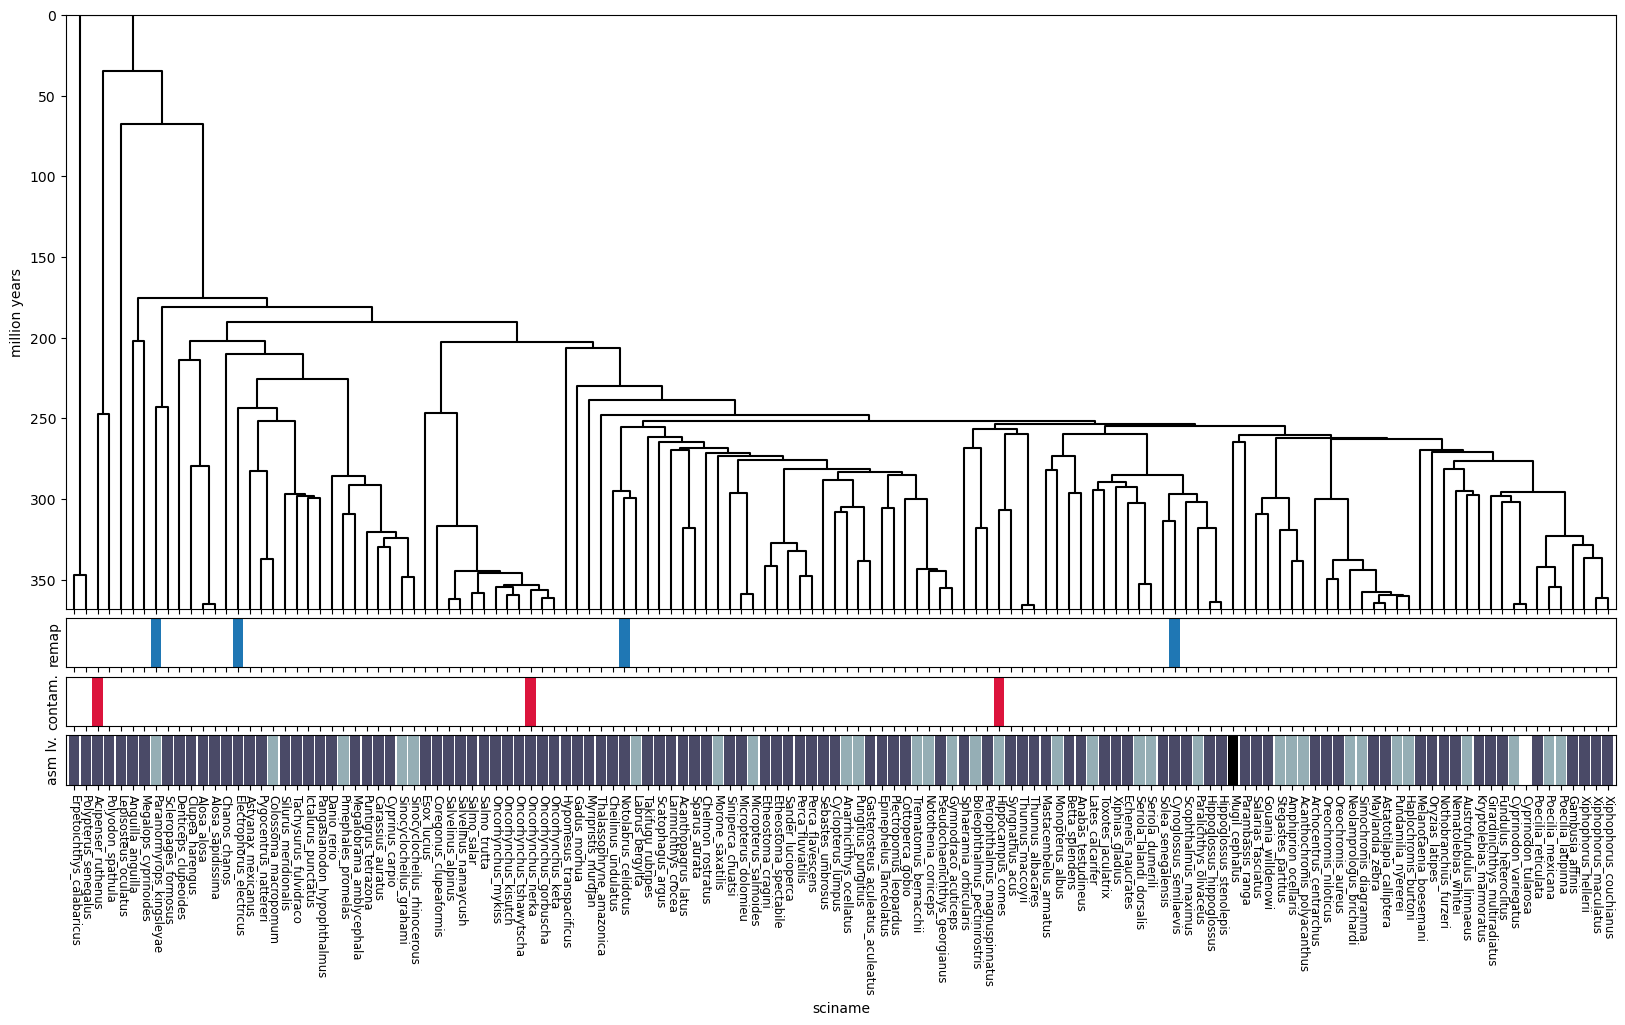

In [20]:
fig, axes = plt.subplots(
    4, sharex=True, figsize=(20, 10), 
    gridspec_kw=dict(height_ratios=[12,1,1,1], hspace=0.05)
)

ax = axes[0]
phyplot.draw(tmp_fish_tree, show_confidence=False, node_text=None, ax=ax)
ax.set_ylabel('million years')

ax = axes[1]
pd.Index(tmp_fish_tree.get_leaf_names()).to_series().isin(altspp.values()).astype(int).plot.bar(stacked=True, width=0.9, ax=ax)
ax.set_ylabel('remap')
ax.yaxis.set_tick_params(left=False, labelleft=False)

ax = axes[2]
contaminated = fish_odbasm['excluded_from_refseq'].eq('contaminated')
contaminated.reindex(tmp_fish_tree.get_leaf_names()).astype(int).plot.bar(color='crimson', stacked=True, width=0.9, ax=ax)
ax.set_ylabel('contam.')
ax.yaxis.set_tick_params(left=False, labelleft=False)

ax = axes[3]
uniques = ('Complete Genome', 'Chromosome', 'Scaffold', 'Contig')
codes = fish_odbasm['assembly_level'].apply(uniques.index)
pd.DataFrame(
    np.eye(len(uniques))[codes], 
    index=fish_odbasm.index, columns=uniques
).reindex(tmp_fish_tree.get_leaf_names()).plot.bar(stacked=True, width=0.9, ax=ax, cmap='bone', legend=False)
ax.set_ylabel('asm lv.')
ax.yaxis.set_tick_params(left=False, labelleft=False)

for ax in axes:
    ax.margins(0)
    
axes[-1].tick_params(axis='x', labelrotation=-90, labelsize='small')

In principle, we excluded genomes annotated as contaminated (O. nerka and H. comes).
Nonetheless we retained Acipenser ruthenus (sterlet) in our analysis because of its lineage-specific WGD event as well as its basal position in the tree.

Most genomes with an assembly level of Scaffold or Contig were excluded from the analysis for rough quality control and computational convenience, while non-Euteleostei species were retained: 
- Paramormyrops_kingsleyae
- Colossoma_macropomum
- Pimephales_promelas
- Sinocyclocheilus_grahami
- Sinocyclocheilus_rhinocerous

In [21]:
target = {*exact_match, *synonym.values(), *altspp.values()}

target -= {
    *contaminated.index[contaminated], 
    *fish_odbasm.index[~fish_odbasm['assembly_level'].isin({'Chromosome','Complete Genome'})], 
}

target |= {
    'Acipenser_ruthenus', 
    'Paramormyrops_kingsleyae', 'Colossoma_macropomum', 'Pimephales_promelas', 
    'Sinocyclocheilus_grahami', 'Sinocyclocheilus_rhinocerous'
}

len(target)

104

<Axes: >

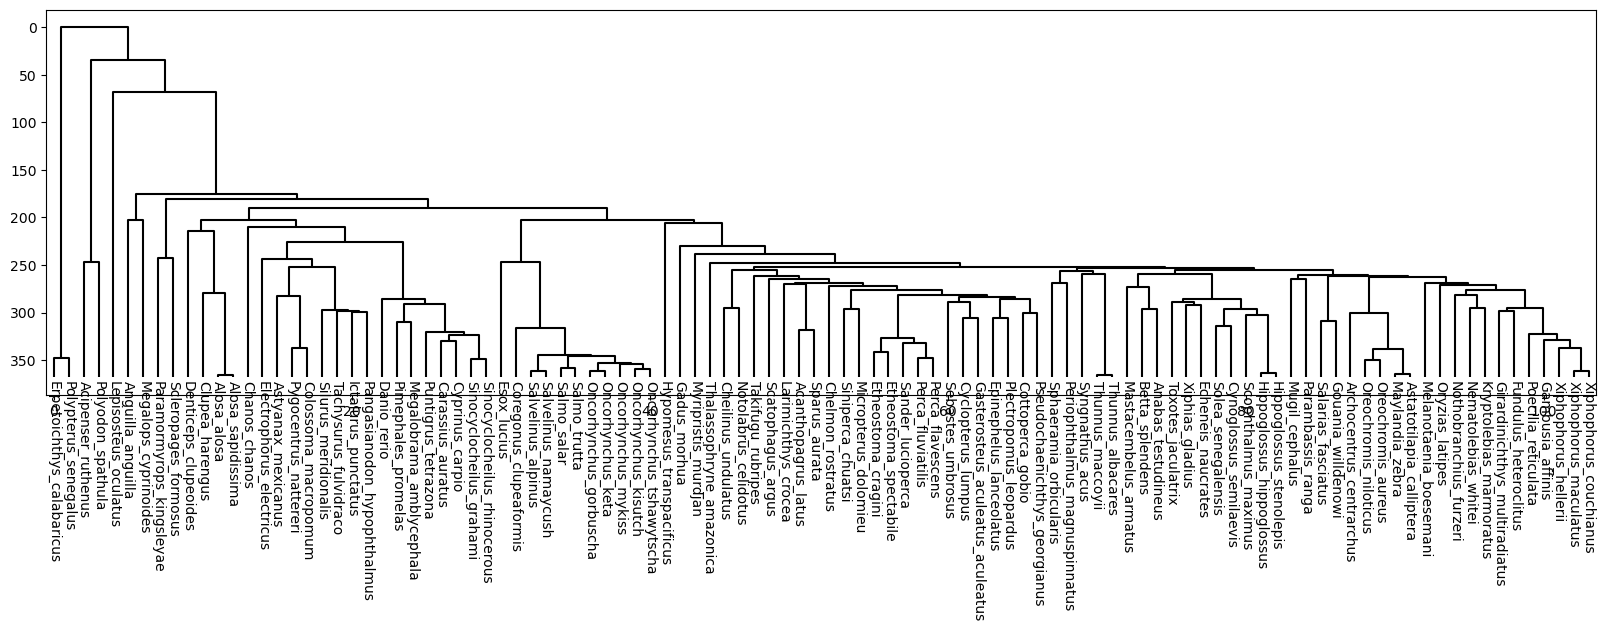

In [22]:
filt_fish_tree = tmp_fish_tree.copy()
filt_fish_tree.prune(target, preserve_branch_length=True)
filt_fish_tree.ladderize()

fig, ax = plt.subplots(figsize=(20, 5))
phyplot.draw(filt_fish_tree, show_confidence=False)

## Combine with profile

In [23]:
fish_table = (
    pd.concat([
        chunk[chunk['OGid'].str.endswith(f'at{actinopt_taxid}')]
        for chunk in tqdm(pd.read_csv(
            ODB11_DIR / 'odb11v0_OG2genes.tab.gz', 
            chunksize=100000, sep='\t', names=['OGid', 'geneid']
        ))
    ]).assign(orgid=lambda df: df['geneid'].str.split(':').str[0])
      #.drop(columns='geneid')
      .groupby(['OGid', 'orgid'])
      .apply(len)
      .unstack()
      .fillna(0)
      .astype(int)
      .rename(columns=dict(map(reversed, fish_odbasm['orgid'].items()))) # orgid => sciname (index)
      .reindex(columns=filt_fish_tree.get_leaf_names())
)

0it [00:00, ?it/s]

In [24]:
phytbl = ExtantPhyTable(
    fish_table.loc[
        fish_table.ne(0).T.sum().ge(len(fish_table.columns) * 0.05), :
    ].to_dict(orient='list'), 
    PostorderSerializedTree(filt_fish_tree)
)

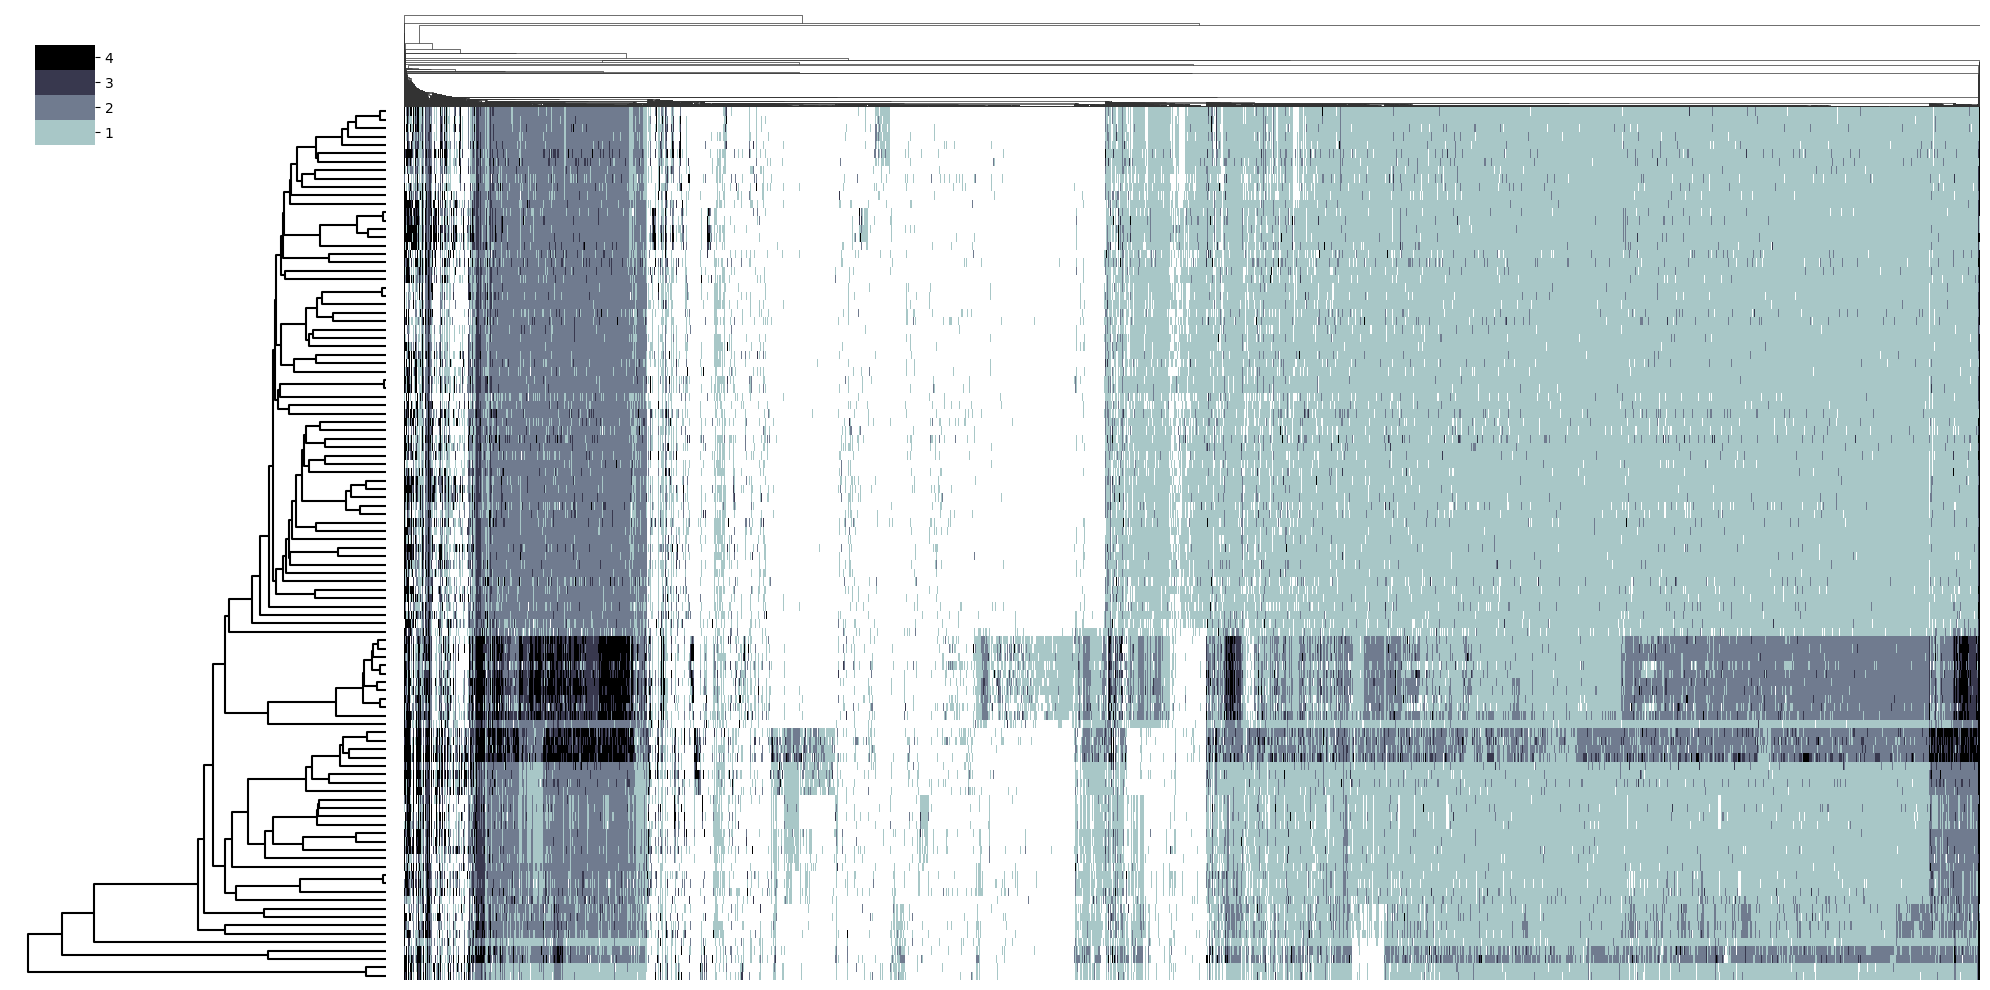

In [25]:
import sys
sys.setrecursionlimit(10000)
dataplot.draw_extant(phytbl, lmax=4)

## Save

In [26]:
with gzip.open(DATASET_DIR/'03-fish'/'fish-main-v0.json.gz', 'wt') as file:
    json.dump({
        'tree': Tree.write(filt_fish_tree, format=3, format_root_node=True),
        'OGs' : fish_table.T.to_dict(orient='split')
    }, file, indent=2)